In [1]:
%pip install shap


  Using cached numpy-2.3.3-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached numpy-2.2.6-cp312-cp312-win_amd64.whl.metadata (60 kB)
   ---------------------------------------- 0.0/12.6 MB ? eta -:--:--
   -------- ------------------------------- 2.6/12.6 MB 21.6 MB/s eta 0:00:01
   ----------------------------------- ---- 11.3/12.6 MB 33.6 MB/s eta 0:00:01
   ---------------------------------------- 12.6/12.6 MB 30.4 MB/s  0:00:00


In [ ]:
%pip install --upgrade --force-reinstall --no-cache-dir numpy==1.26.4 gensim==4.3.3

In [ ]:
%pip install --upgrade --force-reinstall --no-cache-dir scipy==1.11.4 pyLDAvis==3.4.1

In [88]:

from collections import Counter, defaultdict
from typing import List, Dict, Literal, Union

import re
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from sentence_transformers import SentenceTransformer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier


import shap

import warnings

# Add more libraries
import nltk
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import WordNetLemmatizer

from gensim.utils import simple_preprocess
from gensim import corpora
from gensim.models import LdaModel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier  
from lightgbm import LGBMClassifier
from sklearn.svm import LinearSVC
warnings.filterwarnings("ignore")

CACHE_DIR = "./cache"

## Dataset

Load dataset from HuggingFace

In [2]:
# Load the dataset from the specified cache directory
ds = load_dataset("UniverseTBD/arxiv-abstracts-large", cache_dir=CACHE_DIR)
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'report-no', 'categories', 'license', 'abstract', 'versions', 'update_date', 'authors_parsed'],
        num_rows: 2292057
    })
})

In [ ]:
# Compute SVM accuracies for TF-IDF and Embeddings
from sklearn.svm import LinearSVC



print({
    'svm_tfidf_accuracy': svm_tfidf_accuracy,
    'svm_embeddings_accuracy': svm_embeddings_accuracy,
})


In [3]:
# print three first examples
for i in range(3):
    print(f"Example {i+1}:")
    print(ds['train'][i]['abstract'])
    print(ds['train'][i]['categories'])
    print("---" * 20)

Example 1:
  A fully differential calculation in perturbative quantum chromodynamics is
presented for the production of massive photon pairs at hadron colliders. All
next-to-leading order perturbative contributions from quark-antiquark,
gluon-(anti)quark, and gluon-gluon subprocesses are included, as well as
all-orders resummation of initial-state gluon radiation valid at
next-to-next-to-leading logarithmic accuracy. The region of phase space is
specified in which the calculation is most reliable. Good agreement is
demonstrated with data from the Fermilab Tevatron, and predictions are made for
more detailed tests with CDF and DO data. Predictions are shown for
distributions of diphoton pairs produced at the energy of the Large Hadron
Collider (LHC). Distributions of the diphoton pairs from the decay of a Higgs
boson are contrasted with those produced from QCD processes at the LHC, showing
that enhanced sensitivity to the signal can be obtained with judicious
selection of events.

hep-p

In [4]:
all_categories = ds['train']['categories'][:500]
print(set(all_categories))

{'cond-mat.other cond-mat.stat-mech', 'math.PR math.AP', 'cond-mat.supr-con cond-mat.mes-hall', 'cond-mat.stat-mech cond-mat.soft', 'hep-ph nucl-th', 'math.QA hep-th math-ph math.MP math.RT', 'physics.ed-ph quant-ph', 'hep-th gr-qc', 'math.SG math.AG', 'math.AG', 'math.PR q-fin.CP q-fin.PR', 'cond-mat.stat-mech', 'physics.gen-ph quant-ph', 'math.CO math.GT', 'cond-mat.supr-con', 'math.PR math.CA math.ST stat.TH', 'math.NT math.CV', 'physics.comp-ph', 'astro-ph physics.ao-ph', 'cond-mat.mtrl-sci cond-mat.stat-mech', 'math.MG', 'cs.IT cs.CC math.IT', 'cond-mat.str-el cond-mat.mtrl-sci', 'physics.geo-ph', 'physics.pop-ph', 'gr-qc', 'nlin.PS physics.chem-ph q-bio.MN', 'q-bio.NC cond-mat.dis-nn physics.soc-ph', 'math-ph math.MP', 'cs.CC cs.DS', 'cond-mat.str-el cond-mat.stat-mech', 'physics.optics physics.gen-ph quant-ph', 'math.DS', 'physics.flu-dyn physics.comp-ph', 'math.CA math.PR', 'physics.data-an physics.gen-ph', 'nlin.CG', 'cond-mat.stat-mech cond-mat.mtrl-sci', 'math.AG math.GR', '

In [5]:
all_categories = ds['train']['categories']
category_set = set()

# Collect unique labels
for category in all_categories:
    parts = category.split(' ')
    for part in parts:
        topic = part.split('.')[0]
        category_set.add(topic)

# Sort the labels and print them
sorted_categories= sorted(list(category_set), key=lambda x: x.lower())
print(f'There are {len(sorted_categories)} unique primary categories in the dataset:')
for category in sorted_categories:
    print(category)

There are 38 unique primary categories in the dataset:
acc-phys
adap-org
alg-geom
ao-sci
astro-ph
atom-ph
bayes-an
chao-dyn
chem-ph
cmp-lg
comp-gas
cond-mat
cs
dg-ga
econ
eess
funct-an
gr-qc
hep-ex
hep-lat
hep-ph
hep-th
math
math-ph
mtrl-th
nlin
nucl-ex
nucl-th
patt-sol
physics
plasm-ph
q-alg
q-bio
q-fin
quant-ph
solv-int
stat
supr-con


Select first 1000 samples that has single label:

In [6]:
# load 1000 samples with single label belonging to specific categories
samples = []
CATEGORIES_TO_SELECT = ['astro-ph', 'cond-mat', 'cs', 'math', 'physics']
for s in ds['train']:
    if len(s['categories'].split(' ')) != 1:
        continue

    cur_category = s['categories'].strip().split('.')[0]
    if cur_category not in CATEGORIES_TO_SELECT:
        continue

    samples.append(s)

    if len(samples) >= 500:
        break
print(f"Number of samples: {len(samples)}")

for sample in samples[:3]:
    print(f"Category: {sample['categories']}")
    print("Abstract:", sample['abstract'])
    print("#" * 20 + "\n")

Number of samples: 500
Category: physics.gen-ph
Abstract:   The evolution of Earth-Moon system is described by the dark matter field
fluid model proposed in the Meeting of Division of Particle and Field 2004,
American Physical Society. The current behavior of the Earth-Moon system agrees
with this model very well and the general pattern of the evolution of the
Moon-Earth system described by this model agrees with geological and fossil
evidence. The closest distance of the Moon to Earth was about 259000 km at 4.5
billion years ago, which is far beyond the Roche's limit. The result suggests
that the tidal friction may not be the primary cause for the evolution of the
Earth-Moon system. The average dark matter field fluid constant derived from
Earth-Moon system data is 4.39 x 10^(-22) s^(-1)m^(-1). This model predicts
that the Mars's rotation is also slowing with the angular acceleration rate
about -4.38 x 10^(-22) rad s^(-2).

####################

Category: math.CO
Abstract:   We show t

In [7]:
preprocessed_samples = []
for s in samples:
    abstract = s['abstract']

    # Remove \n characters in the middle and leading/trailing spaces
    abstract = abstract.strip().replace("\n", " ")

    # Remove special characters
    abstract = re.sub(r'[^\w\s]', '', abstract)

    # Remove digits
    abstract = re.sub(r'\d+', '', abstract)

    # Remove extra spaces
    abstract = re.sub(r'\s+', ' ', abstract).strip()

    # Convert to lower case
    abstract = abstract.lower()

    # for the label, we only keep the first part
    parts = s['categories'].split(' ')
    category = parts[0].split('.')[0]

    preprocessed_samples.append({
        "text": abstract,
        "label": category
    })

# print first 3 preprocessed samples
for sample in preprocessed_samples[:3]:
    print(f"Label: {sample['label']}")
    print("Text:", sample['text'])
    print("#" * 20 + "\n")

Label: physics
Text: the evolution of earthmoon system is described by the dark matter field fluid model proposed in the meeting of division of particle and field american physical society the current behavior of the earthmoon system agrees with this model very well and the general pattern of the evolution of the moonearth system described by this model agrees with geological and fossil evidence the closest distance of the moon to earth was about km at billion years ago which is far beyond the roches limit the result suggests that the tidal friction may not be the primary cause for the evolution of the earthmoon system the average dark matter field fluid constant derived from earthmoon system data is x sm this model predicts that the marss rotation is also slowing with the angular acceleration rate about x rad s
####################

Label: math
Text: we show that a determinant of stirling cycle numbers counts unlabeled acyclic singlesource automata the proof involves a bijection from 

In [8]:
labels = set([s['label'] for s in preprocessed_samples])
# Sort and print unique labels
sorted_labels = sorted(labels)
for label in sorted_labels:
    print(label)

astro-ph
cond-mat
cs
math
physics


In [9]:
label_to_id = {label: i for i, label in enumerate(sorted_labels)}
id_to_label = {i: label for i, label in enumerate(sorted_labels)}

# Print label to ID mapping
print("Label to ID mapping:")
for label, id_ in label_to_id.items():
    print(f"{label} --> {id_}")

Label to ID mapping:
astro-ph --> 0
cond-mat --> 1
cs --> 2
math --> 3
physics --> 4


In [10]:
X_full = [sample['text'] for sample in preprocessed_samples]
y_full = [label_to_id[sample['label']] for sample in preprocessed_samples]

X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42, stratify=y_full)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 400
Test samples: 100


## Analyzing Dataset

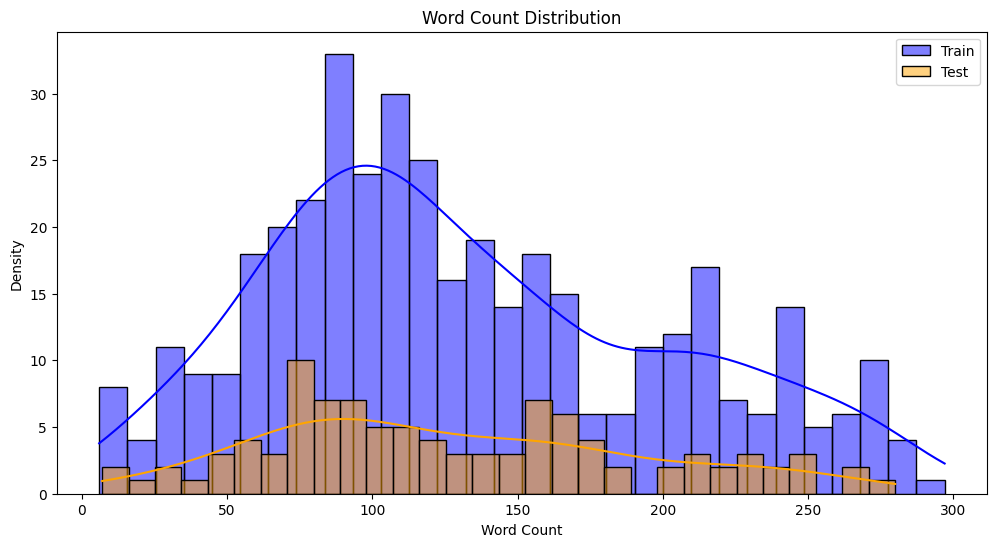

In [11]:
# draw the word count distribution of the train and test sets using matplotlib
train_word_counts = [len(text.split()) for text in X_train]
test_word_counts = [len(text.split()) for text in X_test]
plt.figure(figsize=(12, 6))
sns.histplot(train_word_counts, color='blue', label='Train', kde=True, stat="count", bins=30)
sns.histplot(test_word_counts, color='orange', label='Test', kde=True, stat="count", bins=30)
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Density')
plt.legend()
plt.savefig('word_count_distribution.png')
plt.show()

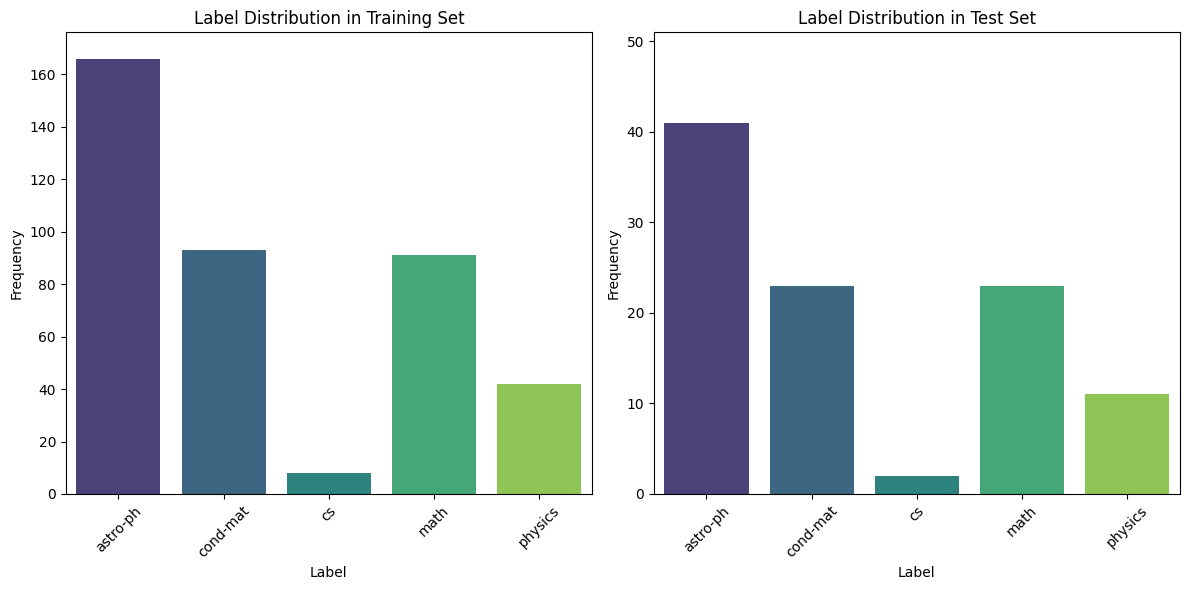

In [12]:
plt.figure(figsize=(12, 6))
train_label_counts = Counter(y_train)
test_label_counts = Counter(y_test)

plt.subplot(1, 2, 1)
sns.barplot(x=list(train_label_counts.keys()), y=list(train_label_counts.values()), palette='viridis')
plt.title('Label Distribution in Training Set')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(ticks=list(train_label_counts.keys()), labels=[id_to_label[i] for i in train_label_counts.keys()], rotation=45)
plt.ylim(0, max(train_label_counts.values()) + 10)

plt.subplot(1, 2, 2)
sns.barplot(x=list(test_label_counts.keys()), y=list(test_label_counts.values()), palette='viridis')
plt.title('Label Distribution in Test Set')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(ticks=list(test_label_counts.keys()), labels=[id_to_label[i] for i in test_label_counts.keys()], rotation=45)
plt.ylim(0, max(test_label_counts.values()) + 10)

plt.tight_layout()
plt.savefig('label_distribution.png')
plt.show()

Top 10 most frequently occurring words in the training set:
model: 164
results: 153
using: 144
also: 138
emission: 132
field: 128
mass: 127
data: 123
show: 121
stars: 121


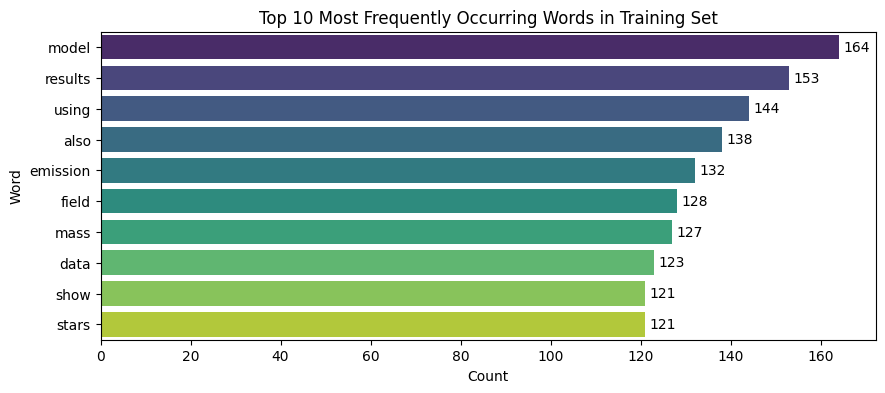

In [13]:
stop_words = set(stopwords.words('english'))

word_counts = Counter()
for text in [*X_train, *X_test]:
    words = text.split()
    words = [word for word in words if word not in stop_words]
    word_counts.update(words)
most_common_words = word_counts.most_common(10)

print("Top 10 most frequently occurring words in the training set:")
for word, count in most_common_words:
    print(f"{word}: {count}")

plt.figure(figsize=(10, 4))
words, counts = zip(*most_common_words)
sns.barplot(x=list(counts), y=list(words), palette='viridis')
plt.title('Top 10 Most Frequently Occurring Words in Training Set')
plt.xlabel('Count')
plt.ylabel('Word')
for i, count in enumerate(counts):
    plt.text(count + 1, i, str(count), va='center')
plt.savefig('top_10_words.png')
plt.show()

In [14]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Create a specific vectorizer for LDA to analyze word frequencies and distributions
lda_vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words="english")
document_term_matrix = lda_vectorizer.fit_transform(X_train)

lda = LatentDirichletAllocation(
    n_components=5,
    random_state=42
)
lda.fit(document_term_matrix)
feature_names = lda_vectorizer.get_feature_names_out()

def display_topics(model, feature_names, no_top_words):
    for index, topic in enumerate(model.components_):
        print(f'The top {no_top_words} words for topic #{index}')
        print([feature_names[i] for i in topic.argsort()[-no_top_words:]], '\n')

display_topics(lda, feature_names, no_top_words=10)

The top 10 words for topic #0
['structure', 'function', 'present', 'observed', 'xray', 'using', 'results', 'data', 'order', 'emission'] 

The top 10 words for topic #1
['functions', 'model', 'high', 'structure', 'redshift', 'galaxies', 'field', 'energy', 'time', 'local'] 

The top 10 words for topic #2
['data', 'methods', 'method', 'new', 'field', 'paper', 'use', 'using', 'results', 'velocity'] 

The top 10 words for topic #3
['state', 'observations', 'surface', 'temperature', 'spin', 'using', 'field', 'magnetic', 'mass', 'model'] 

The top 10 words for topic #4
['observed', 'formation', 'new', 'clusters', 'stellar', 'cluster', 'mass', 'stars', 'galaxies', 'star'] 



In [15]:
topic_results = lda.transform(document_term_matrix)
topic_results

array([[0.59835576, 0.00182537, 0.00182835, 0.00184768, 0.39614284],
       [0.00237526, 0.00238383, 0.00239319, 0.47659832, 0.5162494 ],
       [0.97610366, 0.00601928, 0.00598517, 0.00592908, 0.00596282],
       ...,
       [0.00161171, 0.00160223, 0.00160209, 0.99357064, 0.00161333],
       [0.91858133, 0.02016828, 0.02086588, 0.020321  , 0.02006352],
       [0.00336581, 0.00334034, 0.00332959, 0.98663971, 0.00332455]])

In [16]:
stop_words = set(stopwords.words('english'))

def preprocess(document):
    lemmatizer = WordNetLemmatizer()
    tokens = [t for t in simple_preprocess(document) if t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return tokens

processed_docs = [preprocess(d) for d in X_train]
dictionary = corpora.Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Train LDA model
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=10,
    random_state=42,
)

# Print topics
for i, topic in lda_model.show_topics(formatted=False, num_words=10):
    print(f'Topic {i}: {[word for word, _ in topic]}')

Topic 0: ['spin', 'temperature', 'energy', 'state', 'using', 'field', 'magnetic', 'result', 'system', 'time']
Topic 1: ['cluster', 'model', 'star', 'galaxy', 'result', 'using', 'method', 'two', 'field', 'observed']
Topic 2: ['star', 'system', 'observation', 'model', 'planet', 'result', 'also', 'line', 'state', 'source']
Topic 3: ['model', 'result', 'galaxy', 'energy', 'study', 'temperature', 'show', 'new', 'mass', 'source']
Topic 4: ['star', 'field', 'galaxy', 'period', 'function', 'data', 'spectrum', 'using', 'two', 'state']
Topic 5: ['result', 'model', 'show', 'field', 'number', 'star', 'data', 'emission', 'cluster', 'mass']
Topic 6: ['star', 'model', 'line', 'velocity', 'source', 'quasar', 'result', 'galaxy', 'disk', 'observed']
Topic 7: ['source', 'energy', 'emission', 'star', 'show', 'function', 'model', 'flux', 'also', 'mass']
Topic 8: ['mass', 'galaxy', 'result', 'function', 'using', 'system', 'field', 'data', 'show', 'time']
Topic 9: ['system', 'planet', 'magnetic', 'star', 'fi

In [17]:
#  Predict the topic for each document in the corpus
topic_predictions = lda_model.get_document_topics(corpus)
for i in range(10):
    print(f"Document {i+1} topic distribution: {topic_predictions[i]}")

Document 1 topic distribution: [(8, 0.98573273)]
Document 2 topic distribution: [(2, 0.99107933)]
Document 3 topic distribution: [(5, 0.9795339)]
Document 4 topic distribution: [(0, 0.9795327)]
Document 5 topic distribution: [(5, 0.9943341)]
Document 6 topic distribution: [(4, 0.963971)]
Document 7 topic distribution: [(8, 0.9896438)]
Document 8 topic distribution: [(3, 0.107637286), (8, 0.16882074), (9, 0.7183116)]
Document 9 topic distribution: [(0, 0.98473704)]
Document 10 topic distribution: [(0, 0.98749566)]


In [23]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.005581  0.034215       1        1  14.047570
8     -0.006047  0.005841       2        1  12.227226
1      0.008277  0.015051       3        1  11.228746
6      0.037924 -0.006241       4        1  10.435926
2     -0.016100 -0.037417       5        1  10.169266
3     -0.008932  0.013291       6        1   9.726956
0     -0.086288 -0.017797       7        1   9.268450
9      0.033294 -0.017333       8        1   8.837860
4      0.008607  0.055871       9        1   7.707441
7      0.034847 -0.045480      10        1   6.350559, topic_info=              Term        Freq       Total Category  logprob  loglift
446         planet   60.000000   60.000000  Default  30.0000  30.0000
553         energy   78.000000   78.000000  Default  29.0000  29.0000
85            star  151.000000  151.000000  Default  28.0000  28.0000
149         source   98.000000   98.000000  Default  27.0000  27.0000
1074       cluster   91.000000   91.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
1074       cluster    5.524018   91.202768  Topic10  -5.8657  -0.0474
341           time    5.316728   83.214764  Topic10  -5.9040   0.0061
370          field    5.684539  124.847349  Topic10  -5.8371  -0.3327
22    distribution    4.930555   61.603099  Topic10  -5.9794   0.2314
396       spectrum    4.979287   80.547573  Topic10  -5.9696  -0.0269

[841 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1230      3  0.320661    absorber
1230      9  0.641322    absorber
92        1  0.162504  absorption
92        2  0.065002  absorption
92        3  0.097502  absorption
...     ...       ...         ...
325       9  0.055930        zero
325      10  0.055930        zero
2929      8  0.607383          zn
2930      8  0.607183         zno
4749     10  0.664516          zz

[2256 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 9, 2, 7, 3, 4, 1, 10, 5, 8])

## Text Encoder

### Bag of Words


Bag of Words (BoW) is a simple and commonly used text representation technique. It converts text into a fixed-length vector by counting the occurrences of each word in the text. This method ignores grammar and word order but retains the frequency of words.

In [24]:
docs = [
    "I am going to school to study for the final exam.",
    "The weather is nice today and I feel happy.",
    "I love programming in Python and exploring new libraries.",
    "Data science is an exciting field with many opportunities.",
]

bow = CountVectorizer()
vectors = bow.fit_transform(docs)

for i, vec in enumerate(vectors):
    print(f"Document {i+1}: {vec.toarray()}")

Document 1: [[1 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 2 0 0 0]]
Document 2: [[0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0]]
Document 3: [[0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0]]
Document 4: [[0 1 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1]]


### TF-IDF

Tf-idf (Term Frequency-Inverse Document Frequency) is another popular text representation technique. It not only considers the frequency of words in a document but also how common or rare a word is across all documents. This helps to reduce the weight of common words and highlight more informative ones.

In [25]:
docs = [
    "I am going to school to study for the final exam.",
    "The weather is nice today and I feel happy.",
    "I love programming in Python and exploring new libraries.",
    "Data science is an exciting field with many opportunities.",
]

vectorizer = TfidfVectorizer()
tfidf_vectors = vectorizer.fit_transform(docs)

for i, vec in enumerate(tfidf_vectors):
    print(f"TF-IDF for Document {i+1}:")
    print(vec.toarray())


TF-IDF for Document 1:
[[0.29333722 0.         0.         0.         0.29333722 0.
  0.         0.         0.         0.29333722 0.29333722 0.29333722
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.29333722
  0.         0.29333722 0.23127044 0.58667444 0.         0.
  0.        ]]
TF-IDF for Document 2:
[[0.         0.         0.30091213 0.         0.         0.
  0.         0.38166888 0.         0.         0.         0.
  0.38166888 0.         0.30091213 0.         0.         0.
  0.         0.38166888 0.         0.         0.         0.
  0.         0.         0.30091213 0.         0.38166888 0.38166888
  0.        ]]
TF-IDF for Document 3:
[[0.         0.         0.2855815  0.         0.         0.
  0.36222393 0.         0.         0.         0.         0.
  0.         0.36222393 0.         0.36222393 0.36222393 0.
  0.36222393 0.         0.         0.36222393 0.36222393 0.
  0.         0.         0.         0.

### Word Embeddings

Word embeddings are dense vector representations of words that capture semantic relationships between them. They are typically pre-trained on large corpora and can be used to represent words in a continuous vector space, allowing for better generalization and understanding of word meanings.

In [26]:
class EmbeddingVectorizer:
    def __init__(
        self,
        model_name: str = 'intfloat/multilingual-e5-base',
        normalize: bool = True
    ):
        self.model = SentenceTransformer(model_name)
        self.normalize = normalize

    def _format_inputs(
        self,
        texts: List[str],
        mode: Literal['query', 'passage']
    ) -> List[str]:
        if mode not in {"query", "passage"}:
            raise ValueError("Mode must be either 'query' or 'passage'")
        return [f"{mode}: {text.strip()}" for text in texts]

    def transform(
        self,
        texts: List[str],
        mode: Literal['query', 'passage'] = 'query'
    ) -> List[List[float]]:
        if mode == 'raw':
            inputs = texts
        else:
            inputs = self._format_inputs(texts, mode)

        embeddings = self.model.encode(inputs, normalize_embeddings=self.normalize)
        return embeddings.tolist()

    def transform_numpy(
        self,
        texts: List[str],
        mode: Literal['query', 'passage'] = 'query'
    ) -> np.ndarray:
        return np.array(self.transform(texts, mode=mode))

In [27]:
docs = [
    "I am going to school to study for the final exam.",
    "The weather is nice today and I feel happy.",
    "I love programming in Python and exploring new libraries.",
    "Data science is an exciting field with many opportunities.",
]

vectorizer = EmbeddingVectorizer()
embeddings = vectorizer.transform(docs)

for i, emb in enumerate(embeddings):
    print(f"Embedding for Document {i+1}:")
    print(emb[:10])  # Print first 10 dimensions for brevity
    print("#" * 20)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


Embedding for Document 1:
[-0.014805720187723637, 0.031276557594537735, -0.016158659011125565, 0.007545383181422949, 0.04465829208493233, -0.05123655125498772, -0.014604978263378143, -0.04828919842839241, 0.050347667187452316, 0.004738884512335062]
####################
Embedding for Document 2:
[0.01191742904484272, 0.033273592591285706, -0.025739002972841263, 0.02653307095170021, 0.03160961717367172, -0.021373111754655838, -0.012149662710726261, -0.037848491221666336, 0.041518405079841614, 1.3258098078949843e-05]
####################
Embedding for Document 3:
[0.012662960216403008, 0.039361268281936646, -0.024181142449378967, 0.016197772696614265, 0.007417709566652775, -0.03031235747039318, -0.014685486443340778, -0.03850288689136505, 0.006972402799874544, 0.01775604672729969]
####################
Embedding for Document 4:
[0.006393553223460913, 0.04922203719615936, -0.028402891010046005, -0.013305905275046825, 0.005811015609651804, -0.04371507838368416, -0.00832172017544508, -0.04131

In [28]:
bow_vectorizer = CountVectorizer(
    stop_words="english",
    max_df=0.9,
    min_df=2,
    max_features=3000
)
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

tfidf_vectorizer = TfidfVectorizer(
    stop_words="english",
    max_df=0.9,
    min_df=2,
    max_features=3000
)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

embedding_vectorizer = EmbeddingVectorizer()
X_train_embeddings = embedding_vectorizer.transform(X_train)
X_test_embeddings = embedding_vectorizer.transform(X_test)

# convert all to numpy arrays for consistency
X_train_bow, X_test_bow = np.array(X_train_bow.toarray()), np.array(X_test_bow.toarray())
X_train_tfidf, X_test_tfidf = np.array(X_train_tfidf.toarray()), np.array(X_test_tfidf.toarray())
X_train_embeddings, X_test_embeddings = np.array(X_train_embeddings), np.array(X_test_embeddings)

# Print shapes of the transformed datasets
print(f"Shape of X_train_bow: {X_train_bow.shape}")
print(f"Shape of X_test_bow: {X_test_bow.shape}\n")
print(f"Shape of X_train_tfidf: {X_train_tfidf.shape}")
print(f"Shape of X_test_tfidf: {X_test_tfidf.shape}\n")
print(f"Shape of X_train_embeddings: {X_train_embeddings.shape}")
print(f"Shape of X_test_embeddings: {X_test_embeddings.shape}\n")

Shape of X_train_bow: (400, 2882)
Shape of X_test_bow: (100, 2882)

Shape of X_train_tfidf: (400, 2882)
Shape of X_test_tfidf: (100, 2882)

Shape of X_train_embeddings: (400, 768)
Shape of X_test_embeddings: (100, 768)



## Train and Test Machine Learning Models

In [29]:
def plot_confusion_matrix(y_true, y_pred, label_list, figure_name="Confusion Matrix", save_path=None):
    """
    Plots a confusion matrix with raw counts and normalized values using Seaborn.

    Parameters:
        y_true (array-like): True class labels.
        y_pred (array-like): Predicted class labels.
        label_list (list or dict): Class names (list or dict from ID to name).
        figure_name (str): Title of the plot.
        save_path (str, optional): Path to save the figure. If None, the figure will not be saved.
    """
    # Compute confusion matrix and normalize
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Map class indices to names
    labels = np.unique(y_true)
    if isinstance(label_list, dict):
        class_names = [label_list[i] for i in labels]
    else:
        class_names = [label_list[i] for i in labels]

    # Create annotations with raw + normalized values
    annotations = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            raw = cm[i, j]
            norm = cm_normalized[i, j]
            annotations[i, j] = f"{raw}\n({norm:.2%})"

    # Plot
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=annotations, fmt="", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names,
                cbar=False, linewidths=1, linecolor='black')

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(figure_name)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)

    plt.show()

### KMean

In [35]:
def train_and_test_kmeans(X_train, y_train, X_test, y_test, n_clusters: int):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_ids = kmeans.fit_predict(X_train)

    # Assign label to clusters
    cluster_to_label = {}
    for cluster_id in set(cluster_ids):
        # Get all labels in this cluster
        labels_in_cluster = [y_train[i] for i in range(len(y_train)) if cluster_ids[i] == cluster_id]
        most_common_label = Counter(labels_in_cluster).most_common(1)[0][0]
        cluster_to_label[cluster_id] = most_common_label

    # Predict labels for test set
    test_cluster_ids = kmeans.predict(X_test)
    y_pred = [cluster_to_label[cluster_id] for cluster_id in test_cluster_ids]
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=[id_to_label[i] for i in range(len(id_to_label))], output_dict=True)

    return y_pred, accuracy, report

In [36]:
# Train and test K-Means on different vectorized datasets
km_bow_labels, km_bow_accuracy, km_bow_report = train_and_test_kmeans(X_train_bow, y_train, X_test_bow, y_test, n_clusters=len(label_to_id))
km_tfidf_labels, km_tfidf_accuracy, km_tfidf_report = train_and_test_kmeans(X_train_tfidf, y_train, X_test_tfidf, y_test, n_clusters=len(label_to_id))
km_embeddings_labels, km_embeddings_accuracy, km_embeddings_report = train_and_test_kmeans(X_train_embeddings, y_train, X_test_embeddings, y_test, n_clusters=len(label_to_id))
# Print K-Means results
print("Accuracies for K-Means:")
print(f"Bag of Words: {km_bow_accuracy:.4f}")
print(f"TF-IDF: {km_tfidf_accuracy:.4f}")
print(f"Embeddings: {km_embeddings_accuracy:.4f}")

Accuracies for K-Means:
Bag of Words: 0.4500
TF-IDF: 0.7600
Embeddings: 0.8000


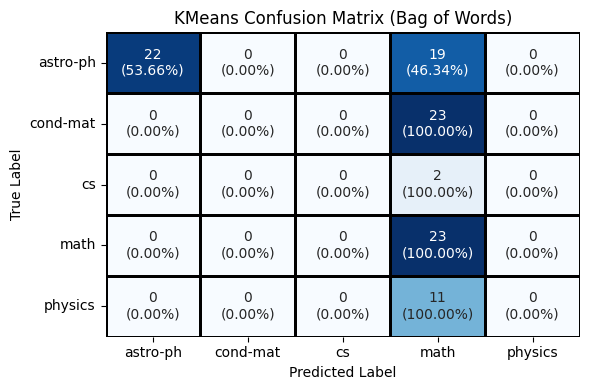

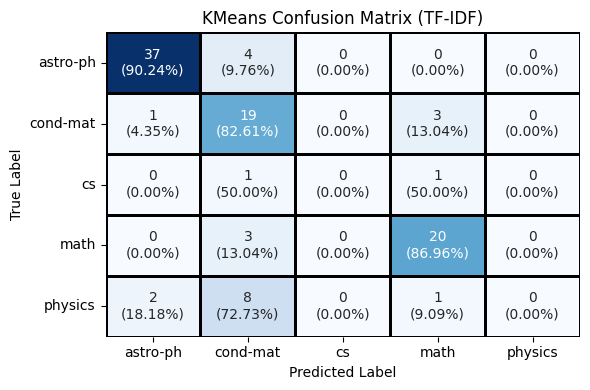

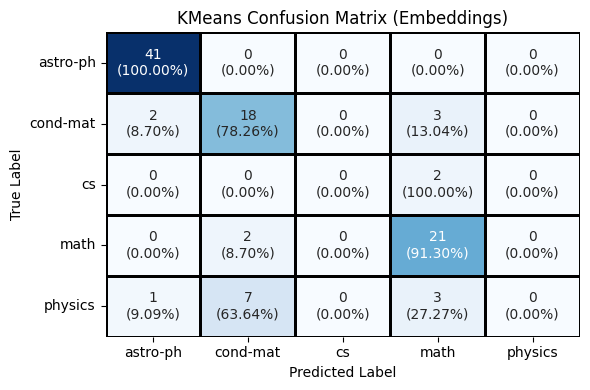

In [37]:
import os
os.makedirs("pdf/Figures", exist_ok=True)

# Draw confusion matrices
plot_confusion_matrix(y_test, km_bow_labels, sorted_labels, "KMeans Confusion Matrix (Bag of Words)", save_path="pdf/Figures/kmeans_bow_confusion_matrix.pdf")
plot_confusion_matrix(y_test, km_tfidf_labels, sorted_labels, "KMeans Confusion Matrix (TF-IDF)", save_path="pdf/Figures/kmeans_tfidf_confusion_matrix.pdf")
plot_confusion_matrix(y_test, km_embeddings_labels, sorted_labels, "KMeans Confusion Matrix (Embeddings)", save_path="pdf/Figures/kmeans_embeddings_confusion_matrix.pdf")

### KNN Classifier

KNN (K-Nearest Neighbors) is a simple and effective classification algorithm that classifies a data point based on the majority class of its k nearest neighbors in the feature space. It is often used for text classification tasks.

In [41]:
def train_and_test_knn(X_train, y_train, X_test, y_test, n_neighbors: int = 5):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)

    # Predict on the test set
    y_pred = knn.predict(X_test)

    # Calculate accuracy and classification report
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=sorted_labels, output_dict=True)

    return y_pred, accuracy, report

In [42]:
knn_bow_labels, knn_bow_accuracy, knn_bow_report = train_and_test_knn(X_train_bow, y_train, X_test_bow, y_test)
knn_tfidf_labels, knn_tfidf_accuracy, knn_tfidf_report = train_and_test_knn(X_train_tfidf, y_train, X_test_tfidf, y_test)
knn_embeddings_labels, knn_embeddings_accuracy, knn_embeddings_report = train_and_test_knn(X_train_embeddings, y_train, X_test_embeddings, y_test)

# Print KNN results
print("Accuracies for KNN:")
print(f"Bag of Words: {knn_bow_accuracy:.4f}")
print(f"TF-IDF: {knn_tfidf_accuracy:.4f}")
print(f"Embeddings: {knn_embeddings_accuracy:.4f}")

Accuracies for KNN:
Bag of Words: 0.3600
TF-IDF: 0.7900
Embeddings: 0.7800


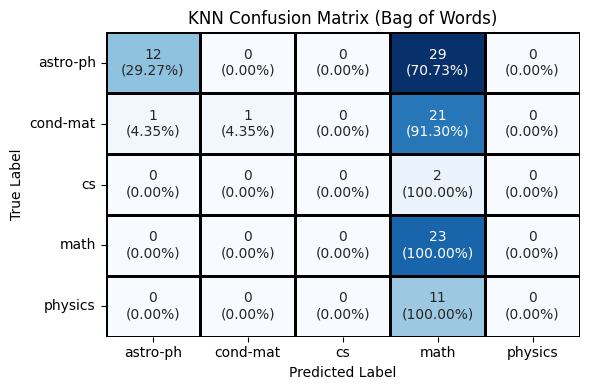

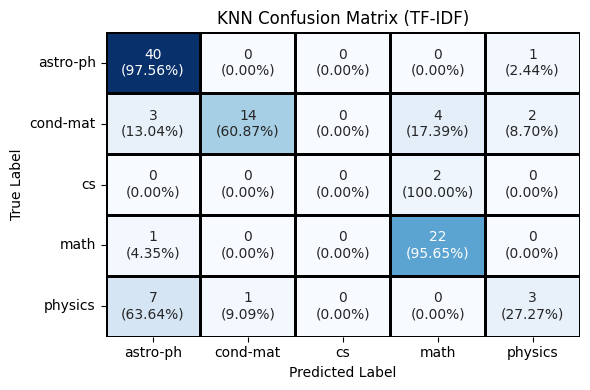

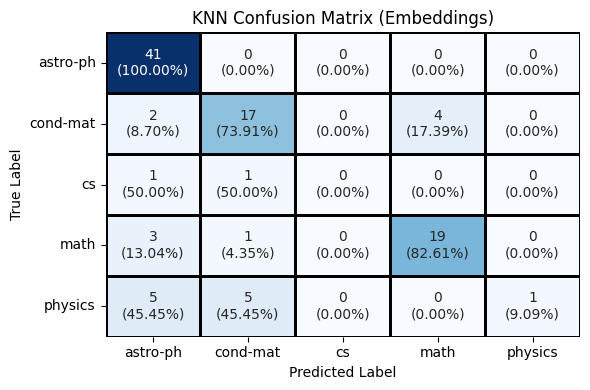

In [43]:
# Draw confusion matrices

plot_confusion_matrix(y_test, knn_bow_labels, sorted_labels, "KNN Confusion Matrix (Bag of Words)", "pdf/Figures/knn_bow_confusion_matrix.pdf")
plot_confusion_matrix(y_test, knn_tfidf_labels, sorted_labels, "KNN Confusion Matrix (TF-IDF)", "pdf/Figures/knn_tfidf_confusion_matrix.pdf")
plot_confusion_matrix(y_test, knn_embeddings_labels, sorted_labels, "KNN Confusion Matrix (Embeddings)", "pdf/Figures/knn_embeddings_confusion_matrix.pdf")

### Decision Tree

In [44]:
def train_and_test_decision_tree(X_train, y_train, X_test, y_test):
    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X_train, y_train)

    # Predict on the test set
    y_pred = dt.predict(X_test)

    # Calculate accuracy and classification report
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=sorted_labels, output_dict=True)

    return y_pred, accuracy, report

In [45]:
dt_bow_labels, dt_bow_accuracy, dt_bow_report = train_and_test_decision_tree(X_train_bow, y_train, X_test_bow, y_test)
dt_tfidf_labels, dt_tfidf_accuracy, dt_tfidf_report = train_and_test_decision_tree(X_train_tfidf, y_train, X_test_tfidf, y_test)
dt_embeddings_labels, dt_embeddings_accuracy, dt_embeddings_report = train_and_test_decision_tree(X_train_embeddings, y_train, X_test_embeddings, y_test)

# Print Decision Tree results
print("Accuracies for Decision Tree:")
print(f"Bag of Words: {dt_bow_accuracy:.4f}")
print(f"TF-IDF: {dt_tfidf_accuracy:.4f}")
print(f"Embeddings: {dt_embeddings_accuracy:.4f}")

Accuracies for Decision Tree:
Bag of Words: 0.6200
TF-IDF: 0.6500
Embeddings: 0.5800


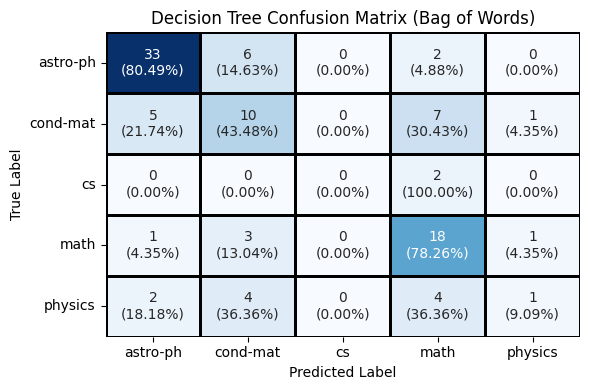

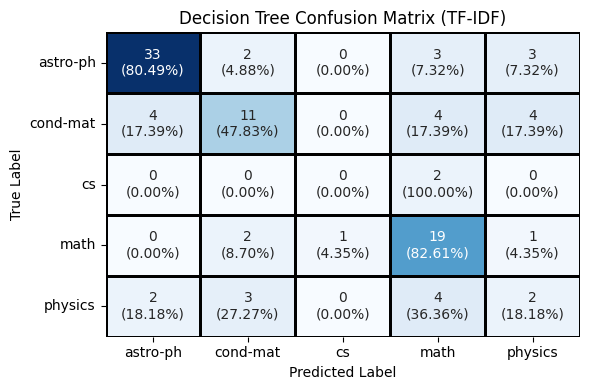

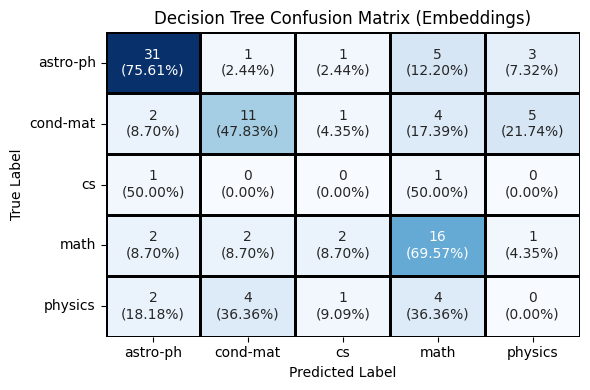

In [46]:
# Draw confusion matrices
plot_confusion_matrix(y_test, dt_bow_labels, sorted_labels, "Decision Tree Confusion Matrix (Bag of Words)", "pdf/Figures/dt_bow_confusion_matrix.pdf")
plot_confusion_matrix(y_test, dt_tfidf_labels, sorted_labels, "Decision Tree Confusion Matrix (TF-IDF)", "pdf/Figures/dt_tfidf_confusion_matrix.pdf")
plot_confusion_matrix(y_test, dt_embeddings_labels, sorted_labels, "Decision Tree Confusion Matrix (Embeddings)", "pdf/Figures/dt_embeddings_confusion_matrix.pdf")

### Naive Bayes

Naive Bayes is a probabilistic classifier based on Bayes' theorem. It assumes that the features are independent given the class label, which simplifies the computation and makes it efficient for text classification tasks.

In [47]:
def train_and_test_naive_bayes(X_train, y_train, X_test, y_test):
    nb = GaussianNB()

    # Naive Bayes requires input to be in dense format
    X_train_dense = X_train.toarray() if hasattr(X_train, 'toarray') else X_train
    X_test_dense = X_test.toarray() if hasattr(X_test, 'toarray') else X_test

    nb.fit(X_train_dense, y_train)

    # Predict on the test set
    y_pred = nb.predict(X_test_dense)

    # Calculate accuracy and classification report
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=sorted_labels, output_dict=True)

    return y_pred, accuracy, report

In [52]:
# Train and test Naive Bayes on different vectorized datasets
nb_bow_labels, nb_bow_accuracy, nb_bow_report = train_and_test_naive_bayes(X_train_bow, y_train, X_test_bow, y_test)
nb_tfidf_labels, nb_tfidf_accuracy, nb_tfidf_report = train_and_test_naive_bayes(X_train_tfidf, y_train, X_test_tfidf, y_test)
nb_embeddings_labels, nb_embeddings_accuracy, nb_embeddings_report = train_and_test_naive_bayes(X_train_embeddings, y_train, X_test_embeddings, y_test)

# Print Naive Bayes results
print("Accuracies for Naive Bayes:")
print(f"Bag of Words: {nb_bow_accuracy:.4f}")
print(f"TF-IDF: {nb_tfidf_accuracy:.4f}")
print(f"Embeddings: {nb_embeddings_accuracy:.4f}")

Accuracies for Naive Bayes:
Bag of Words: 0.7400
TF-IDF: 0.7500
Embeddings: 0.8400


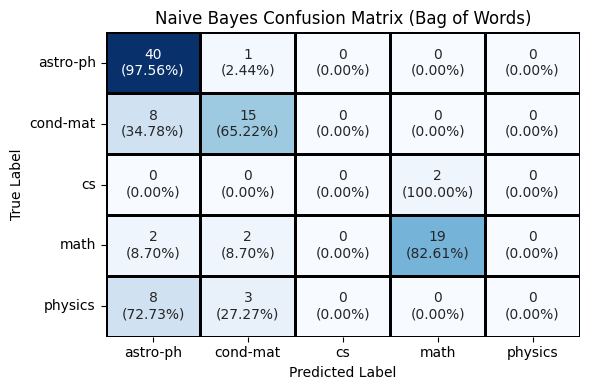

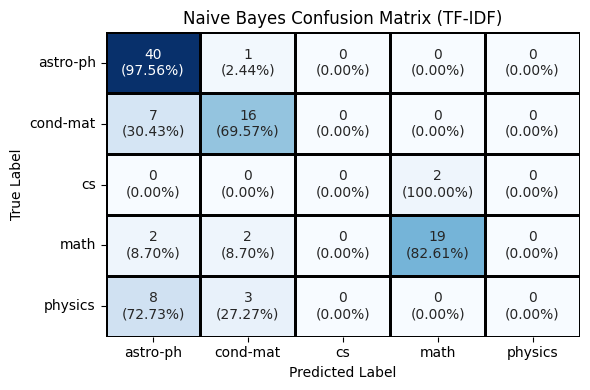

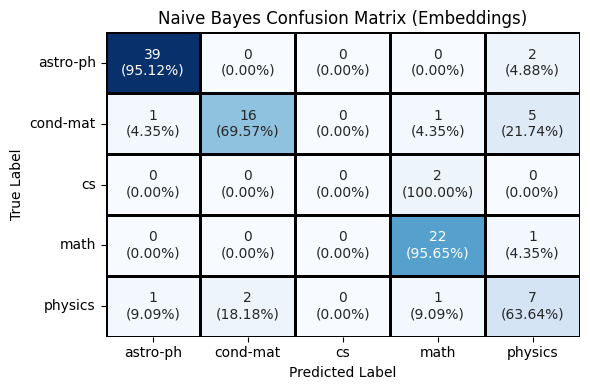

In [53]:
# Draw confusion matrices
plot_confusion_matrix(y_test, nb_bow_labels, sorted_labels, "Naive Bayes Confusion Matrix (Bag of Words)", "pdf/Figures/nb_bow_confusion_matrix.pdf")
plot_confusion_matrix(y_test, nb_tfidf_labels, sorted_labels, "Naive Bayes Confusion Matrix (TF-IDF)", "pdf/Figures/nb_tfidf_confusion_matrix.pdf")
plot_confusion_matrix(y_test, nb_embeddings_labels, sorted_labels, "Naive Bayes Confusion Matrix (Embeddings)", "pdf/Figures/nb_embeddings_confusion_matrix.pdf")

### Random Forest

Random forest is an ensemble learning method that combines multiple decision trees to improve classification performance. It reduces overfitting and increases accuracy by averaging the predictions of individual trees.

In [58]:
def train_and_test_random_forest(X_train, y_train, X_test, y_test, n_estimators: int = 100):
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = rf.predict(X_test)

    # Calculate accuracy and classification report
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=sorted_labels, output_dict=True)

    return y_pred, accuracy, report

In [59]:
rf_bow_labels, rf_bow_accuracy, rf_bow_report = train_and_test_random_forest(X_train_bow, y_train, X_test_bow, y_test)
rf_tfidf_labels, rf_tfidf_accuracy, rf_tfidf_report = train_and_test_random_forest(X_train_tfidf, y_train, X_test_tfidf, y_test)
rf_embeddings_labels, rf_embeddings_accuracy, rf_embeddings_report = train_and_test_random_forest(X_train_embeddings, y_train, X_test_embeddings, y_test)

# Print Random Forest results
print("Accuracies for Random Forest:")
print(f"Bag of Words: {rf_bow_accuracy:.4f}")
print(f"TF-IDF: {rf_tfidf_accuracy:.4f}")
print(f"Embeddings: {rf_embeddings_accuracy:.4f}")

Accuracies for Random Forest:
Bag of Words: 0.7300
TF-IDF: 0.7300
Embeddings: 0.7800


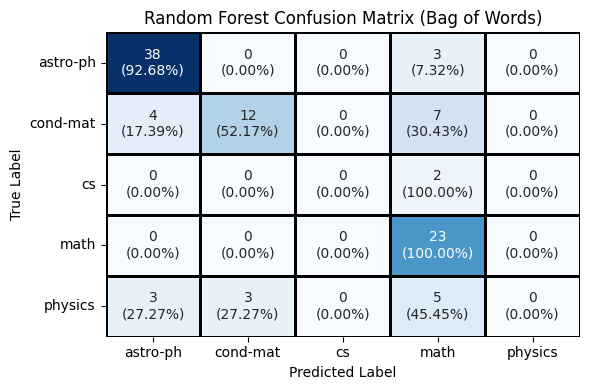

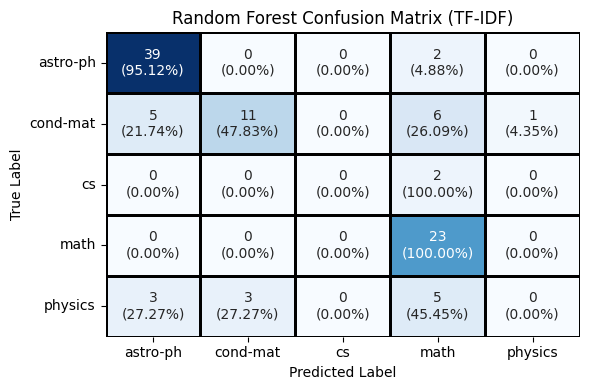

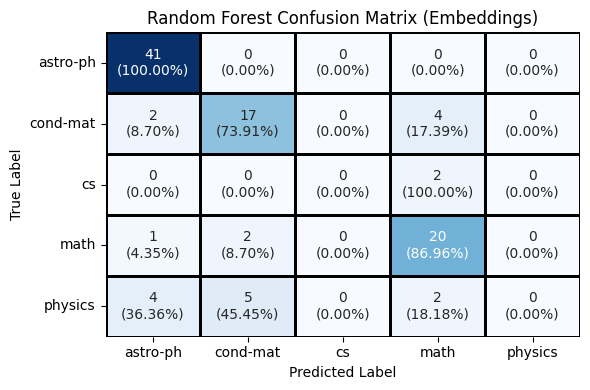

In [60]:
# Draw confusion matrices
plot_confusion_matrix(y_test, rf_bow_labels, sorted_labels, "Random Forest Confusion Matrix (Bag of Words)", "pdf/Figures/rf_bow_confusion_matrix.pdf")
plot_confusion_matrix(y_test, rf_tfidf_labels, sorted_labels, "Random Forest Confusion Matrix (TF-IDF)", "pdf/Figures/rf_tfidf_confusion_matrix.pdf")
plot_confusion_matrix(y_test, rf_embeddings_labels, sorted_labels, "Random Forest Confusion Matrix (Embeddings)", "pdf/Figures/rf_embeddings_confusion_matrix.pdf")

### AdaBoost

AdaBoost, or Adaptive Boosting, is a powerful machine learning algorithm that combines multiple simple, "weak" learning models (like shallow decision trees) to create a single, highly accurate "strong" model. It works by iteratively training these weak learners, with each subsequent model focusing more on the misclassified examples from the previous models by increasing their weights. The final prediction is a weighted average of the predictions from all the weak learners, resulting in a robust classifier.

In [64]:
def train_and_test_adaboost(X_train, y_train, X_test, y_test, n_estimators: int = 50):
    ada = AdaBoostClassifier(n_estimators=n_estimators, random_state=42)
    ada.fit(X_train, y_train)

    # Predict on the test set
    y_pred = ada.predict(X_test)

    # Calculate accuracy and classification report
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=sorted_labels, output_dict=True)

    return y_pred, accuracy, report

In [65]:
ada_bow_labels, ada_bow_accuracy, ada_bow_report = train_and_test_adaboost(X_train_bow, y_train, X_test_bow, y_test)
ada_tfidf_labels, ada_tfidf_accuracy, ada_tfidf_report = train_and_test_adaboost(X_train_tfidf, y_train, X_test_tfidf, y_test)
ada_embeddings_labels, ada_embeddings_accuracy, ada_embeddings_report = train_and_test_adaboost(X_train_embeddings, y_train, X_test_embeddings, y_test)

# Print AdaBoost results
print("Accuracies for AdaBoost:")
print(f"Bag of Words: {ada_bow_accuracy:.4f}")
print(f"TF-IDF: {ada_tfidf_accuracy:.4f}")
print(f"Embeddings: {ada_embeddings_accuracy:.4f}")

Accuracies for AdaBoost:
Bag of Words: 0.6000
TF-IDF: 0.5800
Embeddings: 0.6300


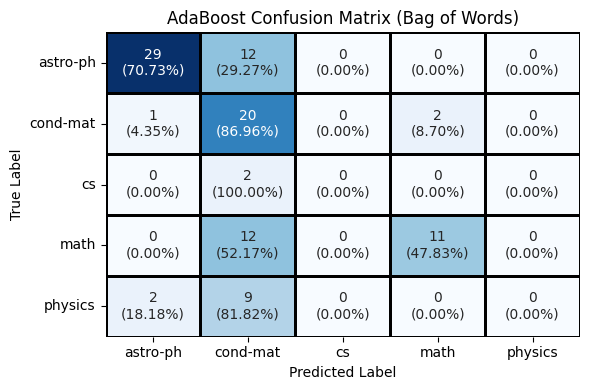

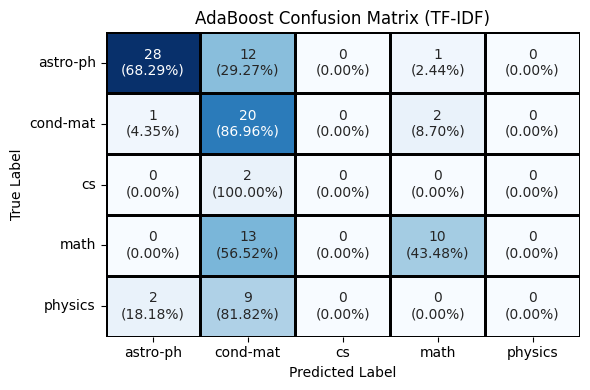

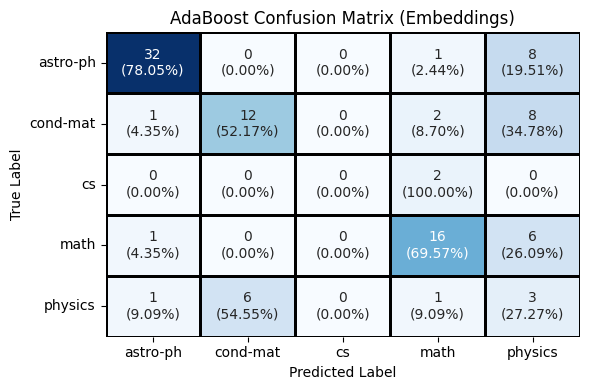

In [66]:
# Draw confusion matrices
plot_confusion_matrix(y_test, ada_bow_labels, sorted_labels, "AdaBoost Confusion Matrix (Bag of Words)", "pdf/Figures/ada_bow_confusion_matrix.pdf")
plot_confusion_matrix(y_test, ada_tfidf_labels, sorted_labels, "AdaBoost Confusion Matrix (TF-IDF)", "pdf/Figures/ada_tfidf_confusion_matrix.pdf")
plot_confusion_matrix(y_test, ada_embeddings_labels, sorted_labels, "AdaBoost Confusion Matrix (Embeddings)", "pdf/Figures/ada_embeddings_confusion_matrix.pdf")

### Gradient Boosting

Gradient boosting is an ensemble machine learning technique that builds decision trees (or other weak learners) sequentially, with each new tree correcting the errors of the previous ones to form a strong, overall predictive model. It works by iteratively minimizing a differentiable loss function, using the gradient to guide the training of each new weak learner. While powerful and versatile for regression and classification, it can be computationally expensive and prone to overfitting, requiring careful hyperparameter tuning.

In [70]:
def train_and_test_gradient_boosting(X_train, y_train, X_test, y_test, n_estimators: int = 100):
    gb = GradientBoostingClassifier(n_estimators=n_estimators, random_state=42)
    gb.fit(X_train, y_train)

    # Predict on the test set
    y_pred = gb.predict(X_test)

    # Calculate accuracy and classification report
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=sorted_labels, output_dict=True)

    return y_pred, accuracy, report

In [71]:
gb_bow_labels, gb_bow_accuracy, gb_bow_report = train_and_test_gradient_boosting(X_train_bow, y_train, X_test_bow, y_test)
gb_tfidf_labels, gb_tfidf_accuracy, gb_tfidf_report = train_and_test_gradient_boosting(X_train_tfidf, y_train, X_test_tfidf, y_test)
gb_embeddings_labels, gb_embeddings_accuracy, gb_embeddings_report = train_and_test_gradient_boosting(X_train_embeddings, y_train, X_test_embeddings, y_test)

# Print Gradient Boosting results
print("Accuracies for Gradient Boosting:")
print(f"Bag of Words: {gb_bow_accuracy:.4f}")
print(f"TF-IDF: {gb_tfidf_accuracy:.4f}")
print(f"Embeddings: {gb_embeddings_accuracy:.4f}")

Accuracies for Gradient Boosting:
Bag of Words: 0.7800
TF-IDF: 0.7200
Embeddings: 0.8100


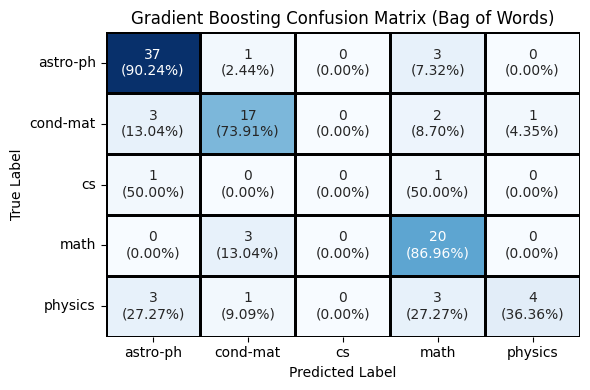

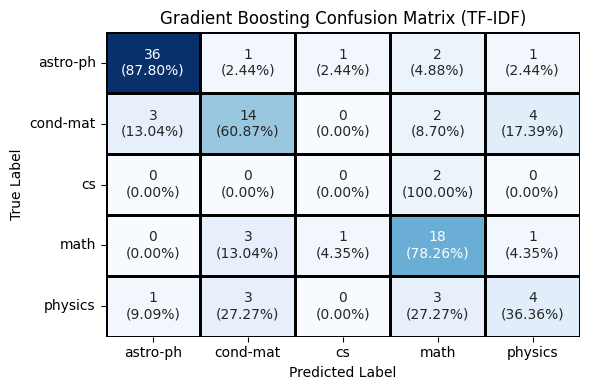

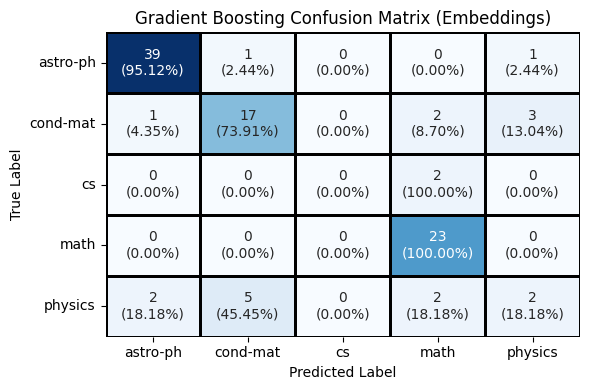

In [72]:
# Draw confusion matrices
plot_confusion_matrix(y_test, gb_bow_labels, sorted_labels, "Gradient Boosting Confusion Matrix (Bag of Words)", "pdf/Figures/gb_bow_confusion_matrix.pdf")
plot_confusion_matrix(y_test, gb_tfidf_labels, sorted_labels, "Gradient Boosting Confusion Matrix (TF-IDF)", "pdf/Figures/gb_tfidf_confusion_matrix.pdf")
plot_confusion_matrix(y_test, gb_embeddings_labels, sorted_labels, "Gradient Boosting Confusion Matrix (Embeddings)", "pdf/Figures/gb_embeddings_confusion_matrix.pdf")

### XGBoost

XGBoost is a widely-used, open-source machine learning library that provides an optimized and scalable implementation of the gradient boosting algorithm for tasks like classification, regression, and ranking. It is known for its speed, accuracy, and ability to handle large datasets through parallel and distributed processing. Key features include built-in regularization to prevent overfitting, efficient handling of missing data, and portability across various platforms and programming languages.

In [78]:
def train_and_test_xgboost(X_train, y_train, X_test, y_test, n_estimators: int = 100):
    xgb = XGBClassifier(
        n_estimators=n_estimators, use_label_encoder=False, eval_metric='mlogloss', random_state=42
    )
    xgb.fit(X_train, y_train)

    # Predict on the test set
    y_pred = xgb.predict(X_test)

    # Calculate accuracy and classification report
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=sorted_labels, output_dict=True)

    return y_pred, accuracy, report

In [79]:
xgb_bow_labels, xgb_bow_accuracy, xgb_bow_report = train_and_test_xgboost(X_train_bow, y_train, X_test_bow, y_test)
xgb_tfidf_labels, xgb_tfidf_accuracy, xgb_tfidf_report = train_and_test_xgboost(X_train_tfidf, y_train, X_test_tfidf, y_test)
xgb_embeddings_labels, xgb_embeddings_accuracy, xgb_embeddings_report = train_and_test_xgboost(X_train_embeddings, y_train, X_test_embeddings, y_test)

# Print XGBoost results
print("Accuracies for XGBoost:")
print(f"Bag of Words: {xgb_bow_accuracy:.4f}")
print(f"TF-IDF: {xgb_tfidf_accuracy:.4f}")
print(f"Embeddings: {xgb_embeddings_accuracy:.4f}")

Accuracies for XGBoost:
Bag of Words: 0.6900
TF-IDF: 0.6700
Embeddings: 0.8000


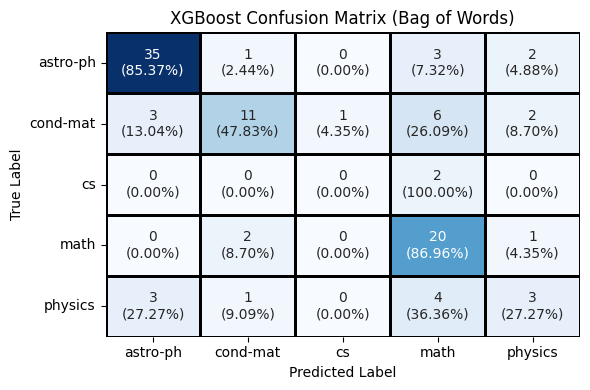

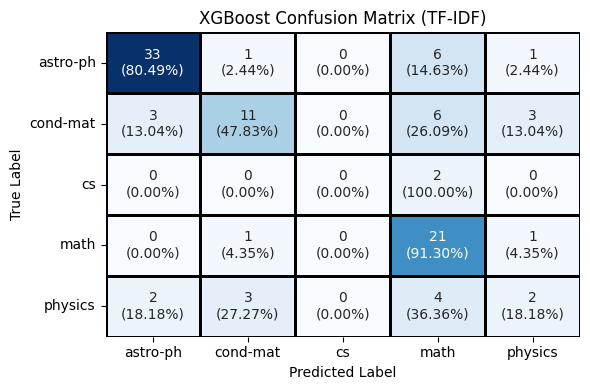

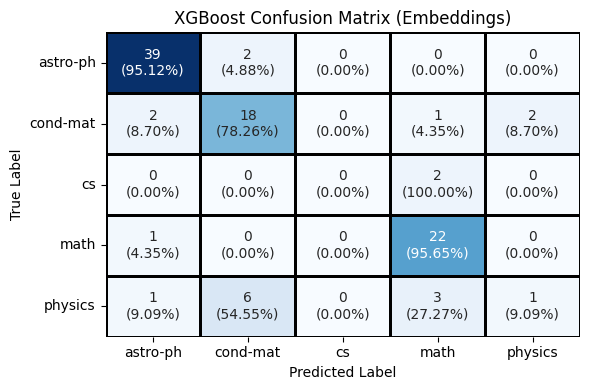

In [80]:
# Draw confusion matrices
plot_confusion_matrix(y_test, xgb_bow_labels, sorted_labels, "XGBoost Confusion Matrix (Bag of Words)", "pdf/Figures/xgb_bow_confusion_matrix.pdf")
plot_confusion_matrix(y_test, xgb_tfidf_labels, sorted_labels, "XGBoost Confusion Matrix (TF-IDF)", "pdf/Figures/xgb_tfidf_confusion_matrix.pdf")
plot_confusion_matrix(y_test, xgb_embeddings_labels, sorted_labels, "XGBoost Confusion Matrix (Embeddings)", "pdf/Figures/xgb_embeddings_confusion_matrix.pdf")

### LightBGM

LightGBM (Light Gradient Boosting Machine) is implemented based on the Gradient Boosting Decision Tree (GBDT) algorithm. It is a gradient boosting framework that utilizes tree-based learning algorithms, specifically optimized decision trees.

Key characteristics and optimizations of LightGBM include:
- Leaf-wise (Best-first) Tree Growth: Unlike many other GBDT implementations that grow trees level-wise, LightGBM grows trees leaf-wise. This means it chooses the leaf with the maximum delta loss to split, which can lead to faster convergence and potentially better accuracy.
- Histogram-based Algorithm: LightGBM employs a histogram-based algorithm to find the best split points, which significantly speeds up the training process, especially with large datasets.
- Reduced Memory Usage: It is designed to be memory-efficient, making it suitable for handling large-scale data.
- Support for Parallel and Distributed Learning: LightGBM supports various parallel and distributed learning strategies, enhancing its scalability for big data problems.


Gradient-based One-Side Sampling (GOSS) is a technique used in the LightGBM algorithm to improve the efficiency of training gradient boosting models. It focuses on selecting a subset of data points based on their gradients, allowing the model to prioritize learning from the most informative samples.

In [83]:
def train_and_test_lightgbm(X_train, y_train, X_test, y_test, n_estimators: int = 100):
    lgbm = LGBMClassifier(boosting_type='goss', n_estimators=n_estimators, random_state=42)
    lgbm.fit(X_train, y_train)

    # Predict on the test set
    y_pred = lgbm.predict(X_test)

    # Calculate accuracy and classification report
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=sorted_labels, output_dict=True)

    return y_pred, accuracy, report

In [84]:
lgbm_bow_labels, lgbm_bow_accuracy, lgbm_bow_report = train_and_test_lightgbm(X_train_bow, y_train, X_test_bow, y_test)
lgbm_tfidf_labels, lgbm_tfidf_accuracy, lgbm_tfidf_report = train_and_test_lightgbm(X_train_tfidf, y_train, X_test_tfidf, y_test)
lgbm_embeddings_labels, lgbm_embeddings_accuracy, lgbm_embeddings_report = train_and_test_lightgbm(X_train_embeddings, y_train, X_test_embeddings, y_test)

# Print LightGBM results
print("Accuracies for LightGBM:")
print(f"Bag of Words: {lgbm_bow_accuracy:.4f}")
print(f"TF-IDF: {lgbm_tfidf_accuracy:.4f}")
print(f"Embeddings: {lgbm_embeddings_accuracy:.4f}")

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 578
[LightGBM] [Info] Number of data points in the train set: 400, number of used features: 143
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score -0.879477
[LightGBM] [Info] Start training from score -1.458865
[LightGBM] [Info] Start training from score -3.912023
[LightGBM] [Info] Start training

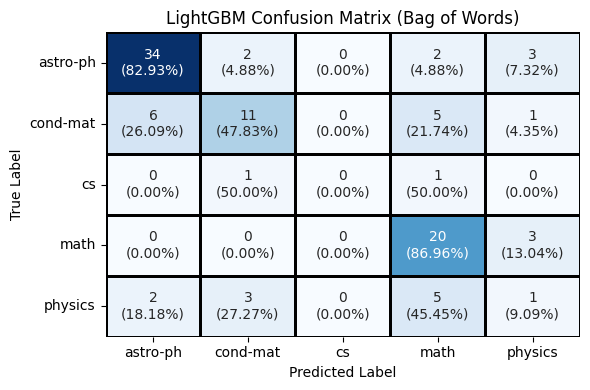

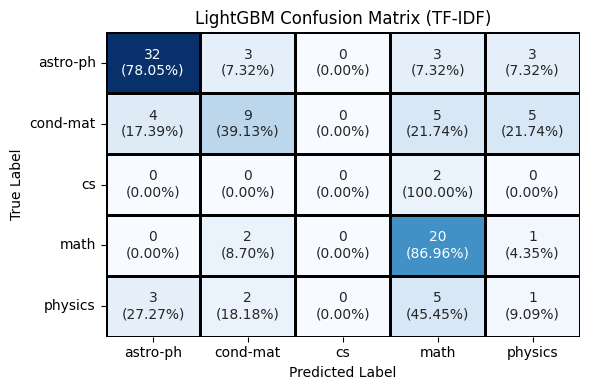

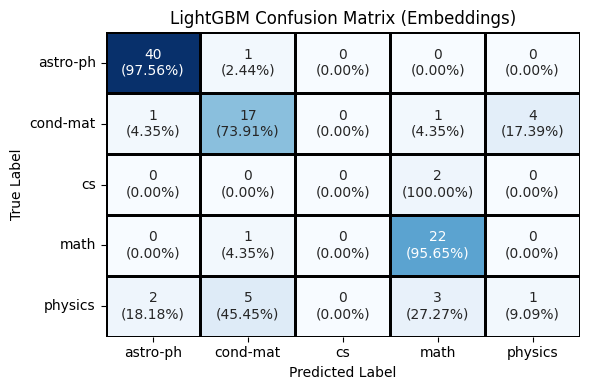

In [85]:
# Draw confusion matrices
plot_confusion_matrix(y_test, lgbm_bow_labels, sorted_labels, "LightGBM Confusion Matrix (Bag of Words)", "pdf/Figures/lgbm_bow_confusion_matrix.pdf")
plot_confusion_matrix(y_test, lgbm_tfidf_labels, sorted_labels, "LightGBM Confusion Matrix (TF-IDF)", "pdf/Figures/lgbm_tfidf_confusion_matrix.pdf")
plot_confusion_matrix(y_test, lgbm_embeddings_labels, sorted_labels, "LightGBM Confusion Matrix (Embeddings)", "pdf/Figures/lgbm_embeddings_confusion_matrix.pdf")

### Aggegate Results

In [91]:
# BoW
svm_bow = LinearSVC(random_state=42)
svm_bow.fit(X_train_bow, y_train)
svm_bow_accuracy = svm_bow.score(X_test_bow, y_test)

# TF-IDF
svm_tfidf = LinearSVC(random_state=42)
svm_tfidf.fit(X_train_tfidf, y_train)
svm_tfidf_accuracy = svm_tfidf.score(X_test_tfidf, y_test)

# Embeddings
svm_embeddings = LinearSVC(random_state=42)
svm_embeddings.fit(X_train_embeddings, y_train)
svm_embeddings_accuracy = svm_embeddings.score(X_test_embeddings, y_test)

In [93]:
# Gather accuracies of all models across all vectorization methods


model_accuracies = {
    "KMeans": {
        "Bag of Words": km_bow_accuracy,
        "TF-IDF": km_tfidf_accuracy,
        "Embeddings": km_embeddings_accuracy
    },
    "KNN": {
        "Bag of Words": knn_bow_accuracy,
        "TF-IDF": knn_tfidf_accuracy,
        "Embeddings": knn_embeddings_accuracy
    },
    "Decision Tree": {
        "Bag of Words": dt_bow_accuracy,
        "TF-IDF": dt_tfidf_accuracy,
        "Embeddings": dt_embeddings_accuracy
    },
    "Naive Bayes": {
        "Bag of Words": nb_bow_accuracy,
        "TF-IDF": nb_tfidf_accuracy,
        "Embeddings": nb_embeddings_accuracy
    },
    "Random Forest": {
        "Bag of Words": rf_bow_accuracy,
        "TF-IDF": rf_tfidf_accuracy,
        "Embeddings": rf_embeddings_accuracy
    },
    "SVM": {
        "Bag of Words": svm_bow_accuracy,
        "TF-IDF": svm_tfidf_accuracy,
        "Embeddings": svm_embeddings_accuracy
    },
    "AdaBoost": {
        "Bag of Words": ada_bow_accuracy,
        "TF-IDF": ada_tfidf_accuracy,
        "Embeddings": ada_embeddings_accuracy
    },
    "Gradient Boosting": {
        "Bag of Words": gb_bow_accuracy,
        "TF-IDF": gb_tfidf_accuracy,
        "Embeddings": gb_embeddings_accuracy
    },
    "XGBoost": {
        "Bag of Words": xgb_bow_accuracy,
        "TF-IDF": xgb_tfidf_accuracy,
        "Embeddings": xgb_embeddings_accuracy
    },
    "LightGBM": {
        "Bag of Words": lgbm_bow_accuracy,
        "TF-IDF": lgbm_tfidf_accuracy,
        "Embeddings": lgbm_embeddings_accuracy
    }
}

# Convert to DataFrame for better visualization
accuracy_df = pd.DataFrame(model_accuracies)
print(accuracy_df)

              KMeans   KNN  Decision Tree  Naive Bayes  Random Forest   SVM  \
Bag of Words    0.45  0.36           0.62         0.74           0.73  0.75   
TF-IDF          0.76  0.79           0.65         0.75           0.73  0.86   
Embeddings      0.80  0.78           0.58         0.84           0.78  0.84   

              AdaBoost  Gradient Boosting  XGBoost  LightGBM  
Bag of Words      0.60               0.78     0.69      0.66  
TF-IDF            0.58               0.72     0.67      0.62  
Embeddings        0.63               0.81     0.80      0.80  


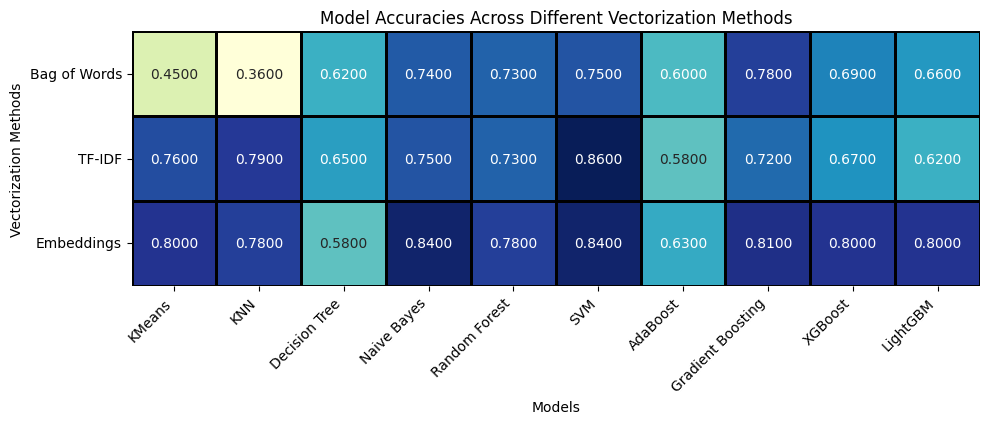

In [94]:
# plot accuracy_df as a heatmap with outline around each cell, and ensure each cell is square
plt.figure(figsize=(10, 6))
sns.heatmap(accuracy_df, annot=True, fmt=".4f", cmap="YlGnBu", cbar=False, linewidths=1, linecolor='black', square=True)
plt.title("Model Accuracies Across Different Vectorization Methods")
plt.xlabel("Models")
# change the angle of x ticks to 45 degrees
plt.xticks(rotation=45, ha='right')
plt.ylabel("Vectorization Methods")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("pdf/Figures/model_accuracies_heatmap.pdf")
plt.show()

# plt.figure(figsize=(10, 6))
# sns.heatmap(accuracy_df, annot=True, fmt=".4f", cmap="YlGnBu")

# # draw outline around each cell
# sns.heatmap(accuracy_df, annot=True, fmt=".4f", cmap="YlGnBu", cbar=False, linewidths=1, linecolor='black', alpha=0)


# plt.title("Model Accuracies Across Different Vectorization Methods")
# plt.xlabel("Models")
# plt.ylabel("Vectorization Methods")
# plt.tight_layout()
# plt.savefig("pdf/Figures/model_accuracies_heatmap.pdf")
# plt.show()

## Explain Model's Predictions with SHAP

Explainable AI (XAI) uses Shapley values, specifically through the SHAP (SHapley Additive exPlanations) framework, to interpret text classification models. For a bag-of-words (BOW) representation, each word in the vocabulary becomes a "player" in a cooperative game. SHAP calculates the average contribution of each word's presence (or absence) to a specific text's classification prediction by comparing its impact across all possible subsets of words in the document. This allows the model to fairly attribute the prediction outcome to individual words, highlighting which words positively or negatively influenced the decision.  

First, we prepare feature names for BoW, TF-IDF, and Word Embeddings representations

In [95]:
bow_vectorizer = CountVectorizer(
    stop_words="english",
    max_df=0.9,
    min_df=2,
    max_features=500
)
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

In [96]:
bow_features = bow_vectorizer.get_feature_names_out()

In [97]:
bow_features

array(['absorption', 'accretion', 'activity', 'addition', 'agreement',
       'algorithm', 'allows', 'analysis', 'analytic', 'anisotropy',
       'antiferromagnetic', 'applications', 'applied', 'approach',
       'approximation', 'area', 'argue', 'associated', 'assuming',
       'asteroids', 'atomic', 'au', 'axis', 'background', 'band', 'based',
       'behavior', 'better', 'bias', 'binaries', 'binary', 'black',
       'bodies', 'boundary', 'brightness', 'bursts', 'calculated',
       'calculations', 'carbon', 'case', 'catalog', 'central', 'certain',
       'characteristic', 'class', 'classical', 'clearly', 'close',
       'cloud', 'cluster', 'clusters', 'cm', 'coefficient',
       'coefficients', 'cold', 'combined', 'common', 'compact',
       'companion', 'compared', 'comparison', 'complete', 'complex',
       'component', 'components', 'condition', 'conditions',
       'conductance', 'conjecture', 'consider', 'considered',
       'consistent', 'constant', 'construct', 'contains', 'c

In [98]:
X_train_bow, X_test_bow = np.array(X_train_bow.toarray()), np.array(X_test_bow.toarray())

In [99]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_bow, y_train)

# Predict on the test set
y_pred = dt.predict(X_test_bow)

# Calculate accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)

In [100]:
accuracy

0.6

In [101]:
bow_explainer = shap.Explainer(dt.predict, X_train_bow, feature_names=bow_features, max_evals=2 * len(bow_features) + 1)
bow_shap_values = bow_explainer(X_test_bow)

PermutationExplainer explainer: 101it [00:17,  3.38it/s]                         


Then, we draw the summary plot for the SVM model with TF-IDF representation to observe the overall impact of features on model output.

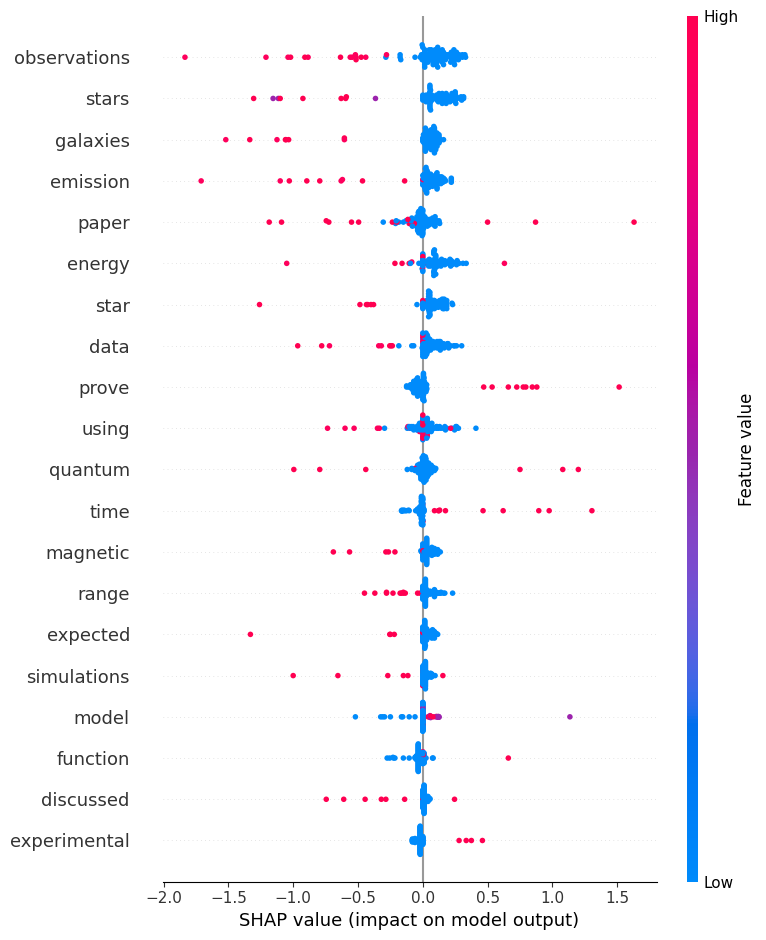

In [102]:
shap.summary_plot(bow_shap_values, feature_names=bow_features, show=False, max_display=20, class_names=sorted_labels)

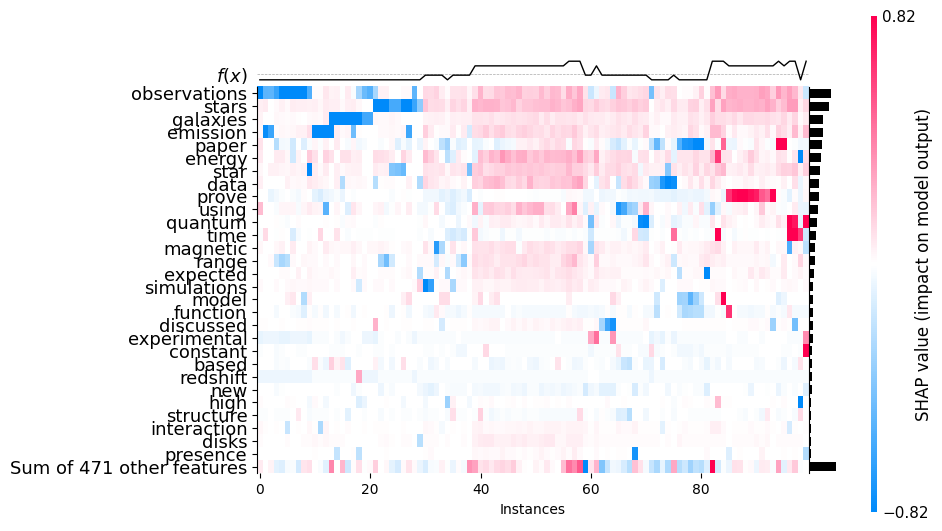

<Axes: xlabel='Instances'>

In [103]:
shap.plots.heatmap(bow_shap_values, max_display=30)

For each unique label in the test subset, we select the first sample of that label and generate a force plot to visualize the contribution of each feature to the model's prediction for that specific publication topic.

SHAP values for class 'astro-ph' (index 1 in test set):


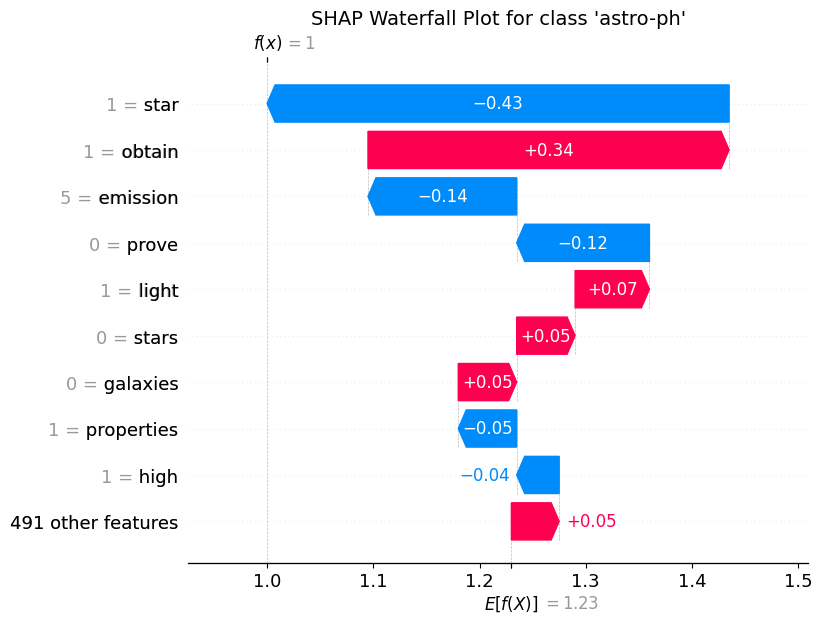



SHAP values for class 'cond-mat' (index 2 in test set):


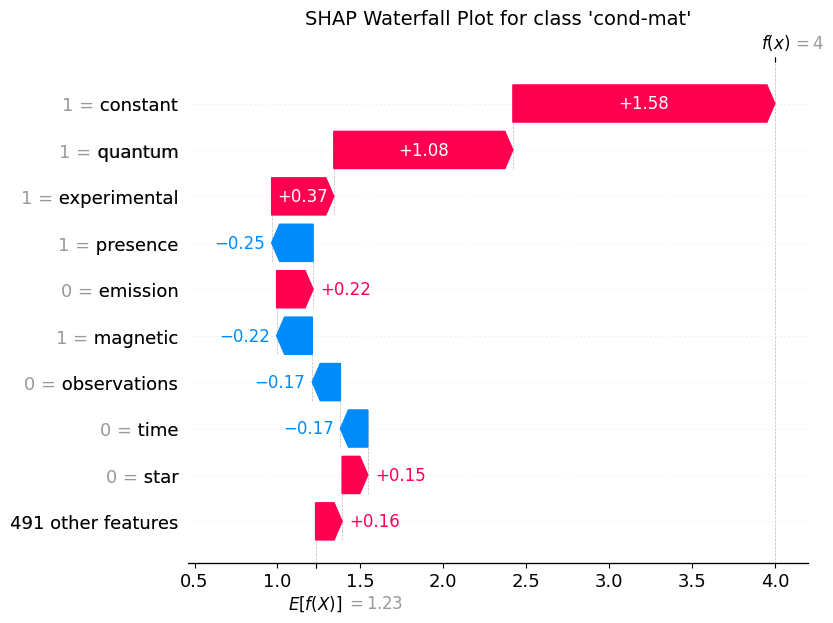



SHAP values for class 'cs' (index 29 in test set):


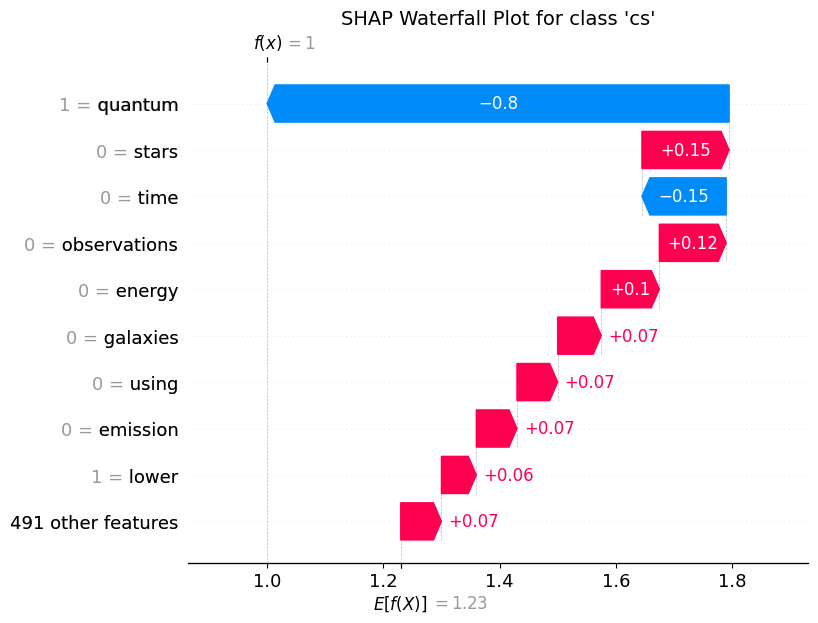



SHAP values for class 'math' (index 0 in test set):


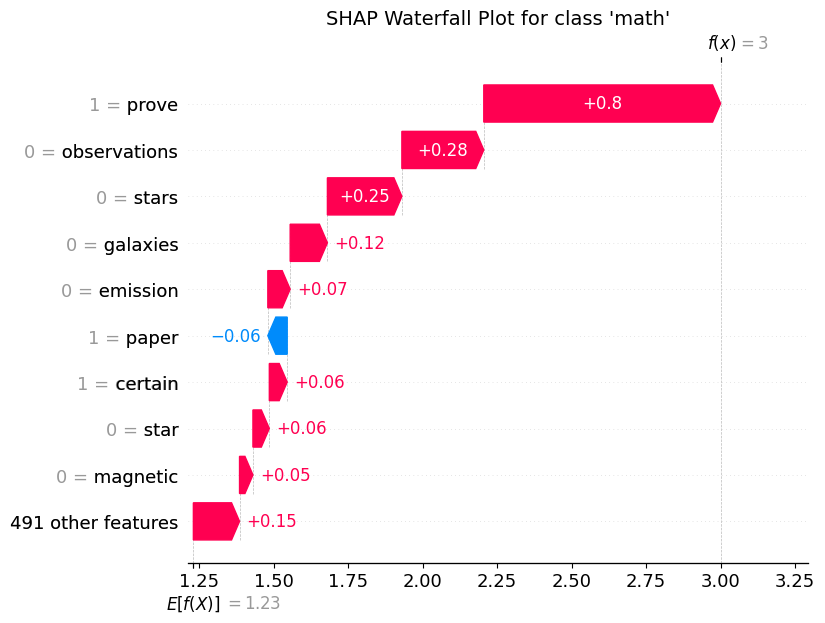



SHAP values for class 'physics' (index 9 in test set):


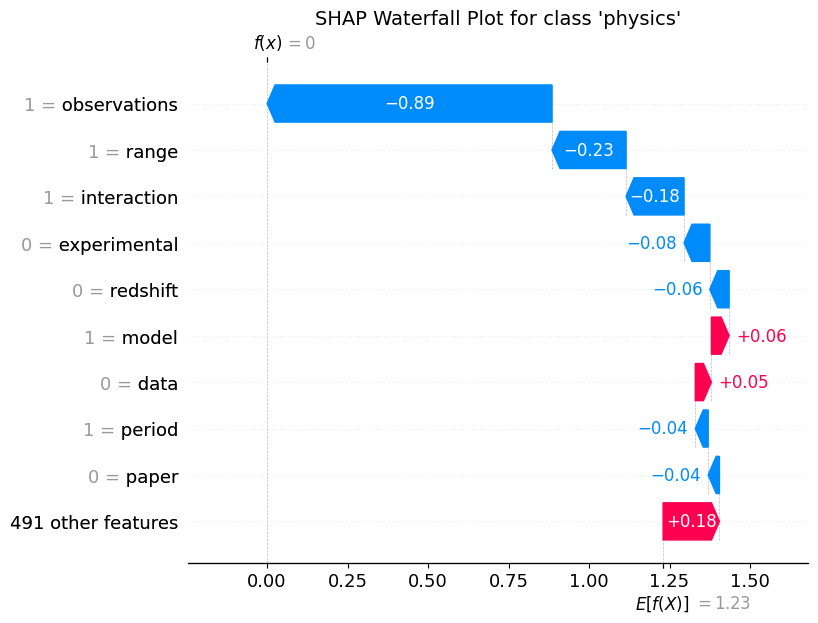

In [104]:
for i in id_to_label:
    class_idx = np.where(np.array(y_test) == i)[0][0]
    print(f"SHAP values for class '{id_to_label[i]}' (index {class_idx} in test set):")

    # Plot title with bigger font
    plt.title(f"SHAP Waterfall Plot for class '{id_to_label[i]}'", fontsize=14)

    shap.plots.waterfall(bow_shap_values[class_idx], max_display=10)
    print("\n")

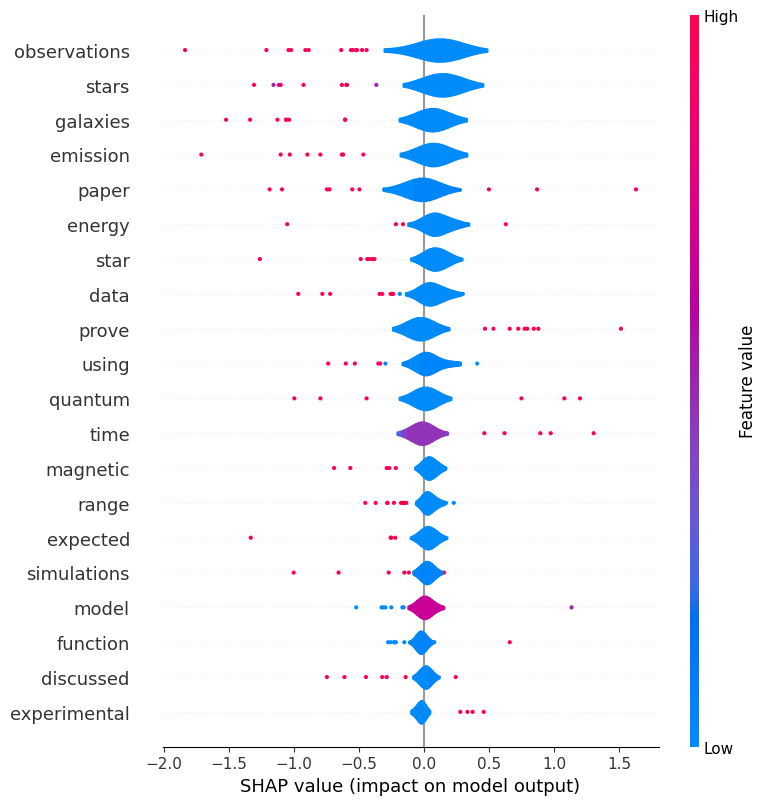

In [105]:
feat_names = list(bow_features)
shap.plots.violin(bow_shap_values, feature_names=feat_names)